In [1]:
import numpy as np
import pandas as pd
import torch

from pytorch_widedeep.preprocessing import WidePreprocessor, DeepPreprocessor
from pytorch_widedeep.models import Wide, DeepDense, WideDeep
from pytorch_widedeep.optim import RAdam
from pytorch_widedeep.initializers import KaimingNormal, XavierNormal
from pytorch_widedeep.callbacks import LRHistory, ModelCheckpoint, EarlyStopping
from pytorch_widedeep.metrics import BinaryAccuracy

In [12]:
df = pd.read_csv('../data/adult/adult.csv.zip')
df.columns = [c.replace("-", "_") for c in df.columns]
df['age_buckets'] = pd.cut(df.age, bins=[16, 25, 30, 35, 40, 45, 50, 55, 60, 91], labels=np.arange(9))
df['income_label'] = (df["income"].apply(lambda x: ">50K" in x)).astype(int)
df.drop('income', axis=1, inplace=True)
df.head()

wide_cols = ['age_buckets', 'education', 'relationship','workclass','occupation',
    'native_country','gender']
crossed_cols = [('education', 'occupation'), ('native_country', 'occupation')]
cat_embed_cols = [('education',16), ('relationship',8), ('workclass',16),
    ('occupation',16),('native_country',16)]
continuous_cols = ["age","hours_per_week"]
target = 'income_label'

target = df[target].values
prepare_wide = WidePreprocessor(wide_cols=wide_cols, crossed_cols=crossed_cols)
X_wide = prepare_wide.fit_transform(df)
prepare_deep = DeepPreprocessor(embed_cols=cat_embed_cols, continuous_cols=continuous_cols)
X_deep = prepare_deep.fit_transform(df)
wide = Wide(wide_dim=X_wide.shape[1], output_dim=1)
deepdense = DeepDense(hidden_layers=[64,32], dropout=[0.5],
                      deep_column_idx=prepare_deep.deep_column_idx,
                      embed_input=prepare_deep.embeddings_input,
                      continuous_cols=continuous_cols)
model = WideDeep(wide=wide, deepdense=deepdense)
model

WideDeep(
  (wide): Wide(
    (wide_linear): Linear(in_features=805, out_features=1, bias=True)
  )
  (deepdense): Sequential(
    (0): DeepDense(
      (embed_layers): ModuleDict(
        (emb_layer_education): Embedding(16, 16)
        (emb_layer_native_country): Embedding(42, 16)
        (emb_layer_occupation): Embedding(15, 16)
        (emb_layer_relationship): Embedding(6, 8)
        (emb_layer_workclass): Embedding(9, 16)
      )
      (dense): Sequential(
        (dense_layer_0): Sequential(
          (0): Linear(in_features=74, out_features=64, bias=True)
          (1): LeakyReLU(negative_slope=0.01, inplace=True)
          (2): Dropout(p=0.0, inplace=False)
        )
        (dense_layer_1): Sequential(
          (0): Linear(in_features=64, out_features=32, bias=True)
          (1): LeakyReLU(negative_slope=0.01, inplace=True)
          (2): Dropout(p=0.5, inplace=False)
        )
      )
    )
    (1): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [13]:
wide_opt = torch.optim.Adam(model.wide.parameters())
deep_opt = RAdam(model.deepdense.parameters())

In [14]:
wide_sch = torch.optim.lr_scheduler.StepLR(wide_opt, step_size=3)
deep_sch = torch.optim.lr_scheduler.StepLR(deep_opt, step_size=5)

In [15]:
initializers = {'wide': KaimingNormal, 'deepdense':XavierNormal}
optimizers = {'wide': wide_opt, 'deepdense':deep_opt}
schedulers = {'wide': wide_sch, 'deepdense':deep_sch}
callbacks = [LRHistory(n_epochs=10), EarlyStopping, ModelCheckpoint(filepath='../model_weights/wd_out')]
metrics = [BinaryAccuracy]

In [16]:
model.compile(method='logistic', initializers=initializers, optimizers=optimizers, lr_schedulers=schedulers,
              callbacks=callbacks, metrics=metrics)

In [17]:
model.fit(X_wide=X_wide, X_deep=X_deep, target=target, n_epochs=10, batch_size=256, val_split=0.2)

valid: 100%|██████████| 39/39 [00:00<00:00, 135.76it/s, loss=0.344, metrics={'acc': 0.8417}]


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

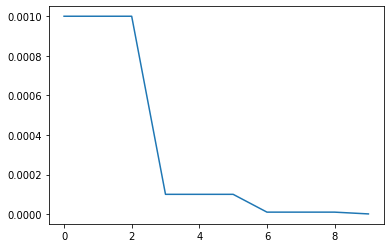

In [19]:
sns.lineplot(x=model.history.epoch, y=model.lr_history['lr_wide_0'])

In [20]:
model.lr_history

{'lr_wide_0': [0.001,
  0.001,
  0.001,
  0.0001,
  0.0001,
  0.0001,
  1.0000000000000003e-05,
  1.0000000000000003e-05,
  1.0000000000000003e-05,
  1.0000000000000002e-06],
 'lr_deepdense_0': [0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001]}